## Sample calculation: 

In [1]:
import scipy
import os
import galsim
import sys
import math
import cmath
import logging
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import sympy
from sympy import Symbol, integrate 

Outline: 
1. Define 5sigma source galaxy above background (DONE)
2. Construct galaxy modeling with Sersic profile (DONE)
3. Define a PSF: start by using a gaussian FWHM = 0.6 (DONE) 
4. Fourier Transform of galaxy, take magntiude (convolve with PSF) (DONE)
5. Remove PSF (DONE)
6. Determine M00, M22 (DONE) 
7. Take e1 and e2 (DONE)

1. Define galaxy above background

In [2]:
#background counts per pixel (assuming gain = 1), input calculation explicitly later 
bckgrd = 1059 # in units of counts/ pixel in 30s exposure 

## 5 sigma above background detection 
npix = 100 
signal = 5*bckgrd*npix**(1/2) 
print(signal)

52950.0


2. make galaxy 

(18, 18)


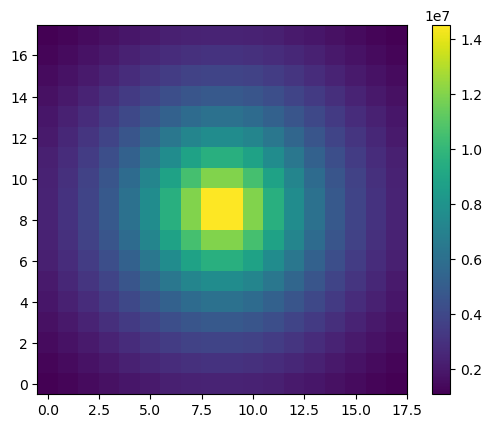

In [3]:
#sersic profile built into galsim 

bckgrd = 1059 # the background counts, as calculated with gain = 1
Npix = 131 # the physical size on the focal plane of the galaxy itself 
# 5 sigma detection
signal = bckgrd*5*Npix**(1/2) #in units of counts/ pixel (10 microns sq) / 30s exposure 

#convert the signal into flux, The flux (in photons/cm^2/s) of the profile
flux =  signal/ 3e-5

# scale factor b, approximate 
n = 1
b = 2*n - 1/3 
FWHM = 0.6

# determine what we want as the half light radius
# using a FWHM = 0.6 (or 3 pixels)
# I(r=FWHM) = 0.5*I0 = I0*exp(-b(r/re)) 

re = -FWHM*b/(math.log(0.5))
sersic_gal = galsim.Sersic(n=n, half_light_radius= re, flux=flux, trunc=6)

image = sersic_gal.drawImage(nx=18, ny=18, scale=0.2)
im0 = plt.imshow(image.array, origin='lower', interpolation='None')    
plt.colorbar()
print(image.array.shape)

In [4]:
# take the fourier transform 



3. Define PSF 

(18, 18)


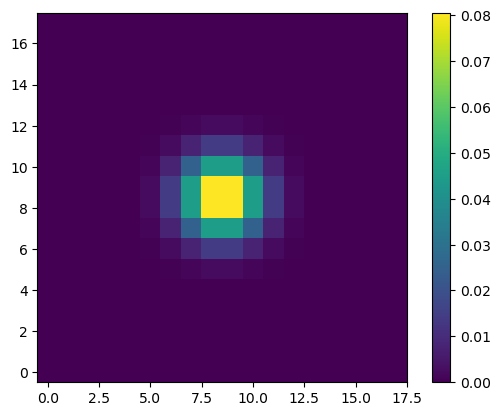

In [5]:
# want the FWHM to be 0.6" which is 3 pixels 
psf = galsim.Gaussian(fwhm=0.6, flux=1.0)

#visualize the PSF 
image = psf.drawImage(scale=0.2)
im0 = plt.imshow(image.array, origin='lower', interpolation='None')    
plt.colorbar()

# transform into fourier power function of the PSF 
FFTpsf = galsim.fft.fft2(image.array) 
G = abs(FFTpsf)**2 # fourier power spectrum of the PSF 
print(G.shape)

In [6]:
# Use G to determine rpp 
# A is the area where the value is e^(-0.5) times the maximum of G (noiseless fourier power function of the psf) 
gmax = G.max()
ncriteria = 0 
for pixel in G.flatten(): 
    if pixel > gmax*math.exp(-0.5):
        ncriteria += 1

# rpp = scale radius of the PSF in fourier space 
# converted number of pixels to an area of pixel (in arcsec^2) 
rpp = (ncriteria*(0.2)*(0.2)/math.pi)**(1/2)

#use this to calculate sigma for shapelet basis functions 
beta = 0.85 # effective scale radius in fourier space, set to 0.85 (Li 2018)
sigma = beta* rpp 

alpha = 4 # effective scale in configuration space, set to 4 (Li 2018)

4. Convolve psf and galaxy together 

In [7]:
# convolve the galaxy and psf (psf, sersic_gal) (integral 2d of psf*galaxy) 
colv = galsim.Convolution([sersic_gal, psf], real_space=True)
# take the fourier transform, need to make this into an image 
convolveimage = colv.drawImage(nx=18, ny=18, scale=0.2)
FFTcolv = galsim.fft.fft2(convolveimage.array) 
F = abs(FFTcolv)**2 

5. Remove the PSF

In [8]:
print(F.shape)
print(G.shape)

(18, 18)
(18, 18)


In [9]:
Fnopsf = F/ G

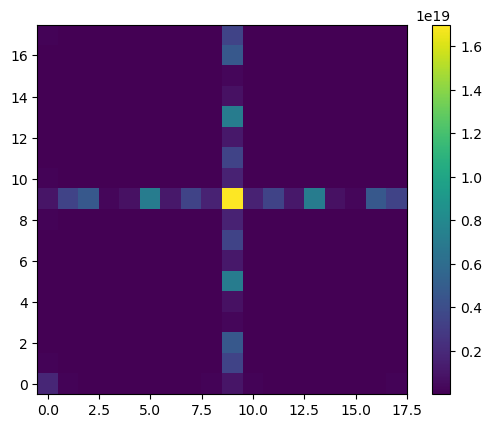

In [10]:
plt.imshow(Fnopsf, origin='lower', interpolation='None')
plt.colorbar()

6. Determine M00 and M22 

Notes: 
1. I calculated Xnm polar shapelet basis functions by hand, Li 2018, and took their complex conjugate and inputted here as Xnmstar 
2. Both K and rho/phi are used to denote fourier space 
3. Li 2021 suggests calculating Mnm by summation over k space of Xnmstar*Fnopsf 
4. Evaluate Xnm at specific location then multiply by Fnopsf 

In [11]:
def X00Star(r): #evaluate X00star for a specified value of r 
    return  (r**2* math.exp(-(r**2)/(2*sigma**2)))/(math.pi**(1/2)*sigma**3)
    
def X22Star(r, t):
    return  (r**4* sympy.exp(-(r**2)/(2*sigma**2))*sympy.exp(2j*t))/(math.pi**(1/2)*2**(1/2)*sigma**5)

def X22StarTrig(r, t): # using Eulers formula, kill the complex exponential (I think python is having an issue with how I am using it) 
    z = complex(math.cos(2*t), math.sin(2*t)) 
    return  (r**4* math.exp(-(r**2)/(2*sigma**2))*z)/(math.pi**(1/2)*2**(1/2)*sigma**5)


def calculateListMnm(F):
    M00array = []
    M22array = []
    for idx, x in np.ndenumerate(F): 
        # determine the position in the array, convert to its position in F.S. (rho, phi)
        nr = idx[0] 
        nc = idx[1] 
        x = nc - 9 # index of the column 
        y = 9 - nr # index of the row 
        r = (x**2 + y**2)**(1/2) # rho 
        
        if x == 0: 
            if y > 0: 
                t = math.pi/ 2
            elif y < 0: 
                t = 3*math.pi/2 
        else:     
            t = np.arctan(y/x) 

        # evaluate the shapelet basis functions at position 
        # evaluate function X00star 
        X00= X00Star(r)
        # evaluate function X22star 
        X22 = X22StarTrig(r, t)
        M00array.append(X00*x)
        M22array.append(X22*x)
        
    return M00array, M22array


In [12]:
M00array, M22array = calculateListMnm(Fnopsf)

In [13]:
M00 = sum(M00array) 
M22 = sum(M22array) 

In [14]:
print(M00)
print(M22)

-7.676937352546731e-19
(-6.5074737195239724e-18-1.2265655568575401e-18j)


In [15]:
# real
M22C = M22.real
# imaginary 
M22S = M22.imag
print(M00)
print(M22C)
print(M22S)

-7.676937352546731e-19
-6.5074737195239724e-18
-1.2265655568575401e-18


7. Determine e1 and e2 

In [16]:
# MnmC is the real part, MnmS is the imaginary part 
# C adjusts therelativeweightbetween galaxiesof different luminosities
C = 1
e1 = M22C / (M00 + C) 
e2 = M22S / (M00 + C) 

In [17]:
print(e1)
print(e2)

-6.5074737195239724e-18
-1.2265655568575401e-18
